In [3]:
# Warning: this notbook is amidst some kitchen work. 
# Avoid viewing to ensure mind safety.
import numpy as np
import scipy as sp
from scipy import stats as st
from collections import defaultdict
#import src.main.python.crayfis.crayfis_data_pb2 as crayon_proto

import gzip
from sklearn.externals import joblib as jl
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

#problem-specific gamma fit patch

In [13]:
from scipy.stats._continuous_distns import gamma_gen
from scipy.stats._distn_infrastructure import argsreduce
from scipy.stats._constants import _XMAX
##try: LANDAU distribution
##forget it, try 2 gammas (sum of 2 RV)
##no, try betta...

class GammaWeighted(gamma_gen):
    '''warning: built for data = np.arange(N)'''
    def _reduce_func(self, args, kwds):
        x0,func,restore,args = gamma_gen._reduce_func(self,args,kwds)
        if 'weights' in kwds:
            
            self.w = kwds['weights']
            func = self._penalized_weighted_nnlf
        return x0,func,restore,args
    def fit_weighted(self,weights,data = None,*args,**kwargs):
        if data is None:
            data =np.arange(weights.shape[0],dtype= np.int64)
        return self.fit(data, weights = weights)
        
    def _penalized_weighted_nnlf(self,theta,data):
        ''' Return negative loglikelihood function,
        i.e., - sum (log pdf(x, theta), axis=0)
           where theta are the parameters (including loc and scale)
        '''
        try:
            loc = theta[-2]
            scale = theta[-1]
            args = tuple(theta[:-2])
        except IndexError:
            raise ValueError("Not enough input arguments.")
        if not self._argcheck(*args) or scale <= 0:
            return np.inf

        x = np.asarray((data-loc) / scale)

        loginf = np.log(_XMAX)

        if np.isneginf(self.a).all() and np.isinf(self.b).all():
            Nbad = 0
        else:
            cond0 = (x <= self.a) | (self.b <= x)
            Nbad = sum(self.w[cond0])
            if Nbad > 0:
                x = argsreduce(~cond0, x)[0]
                data = argsreduce(~cond0, data)[0]

        N = len(x)
        lpdf = self._logpdf(x, *args)
        nnlf = -np.sum(lpdf*self.w[data])
        
        return nnlf + N*np.log(scale) + Nbad * 100.0 * loginf


gammaWeighted = GammaWeighted(name = 'gamma', a = 0)


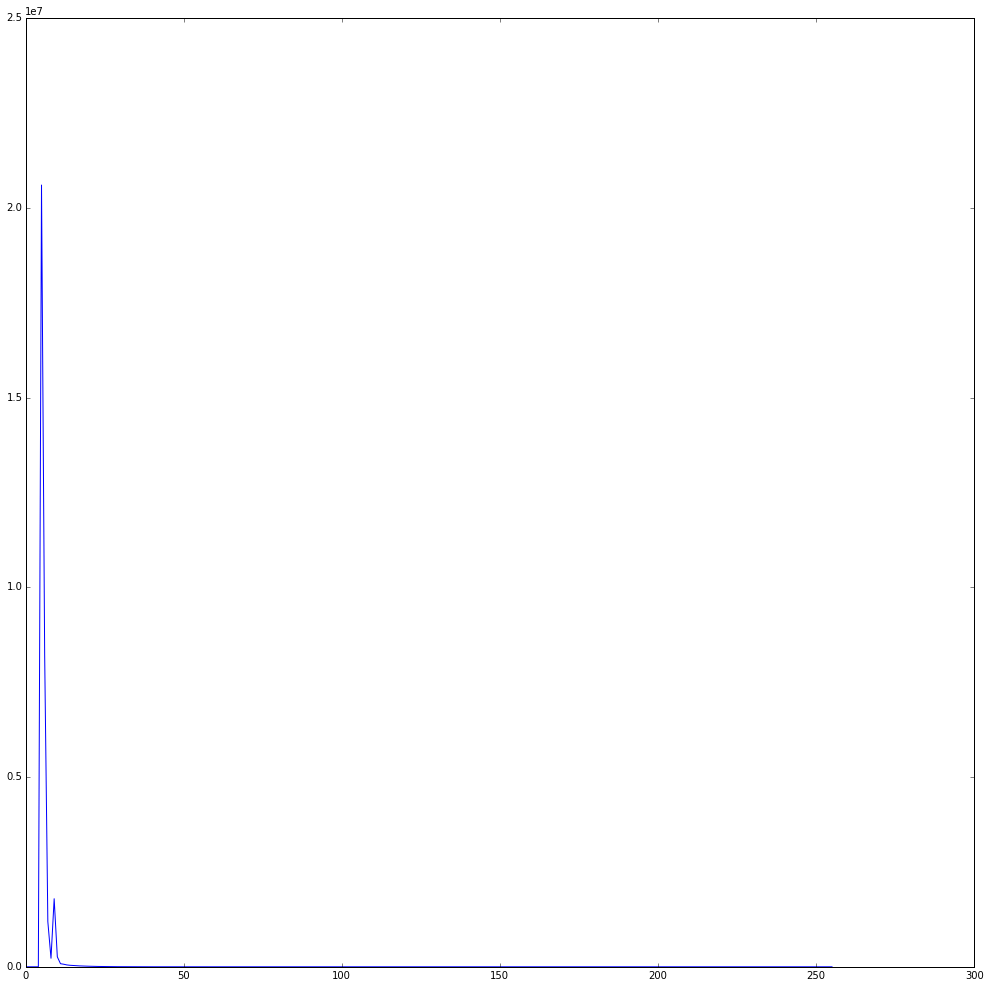

In [68]:
chist = np.sum(hists,axis = (0,1))
plt.figure(figsize=[17,17])
#plt.xlim([0,20])
plt.plot(chist)

In [62]:
chist

array([       0,        0,        0,        0,        0, 20603135,
        8208962,  1189863,   225303,  1794455,   263010,    81439,
          68037,    49740,    40107,    34219,    28574,    23848,
          20033,    17437,    15036,    12411,    10720,     9025,
           7586,     6625,     5189,     4580,     4070,     3228,
           2725,     2364,     1930,     1608,     1403,     1146,
            976,      799,      708,      561,      496,      345,
            315,      286,      214,      194,      147,      114,
            103,       87,       49,       61,       55,       45,
             37,       28,       17,       20,       10,        5,
             12,        7,        4,        5,        1,        2,
              5,        2,        5,        2,        1,        0,
              2,        1,        1,        3,        1,        0,
              1,        1,        1,        1,        0,        3,
              0,        0,        0,        0,        1,      

#some simple EDA

In [7]:
pixelHists = hists.reshape(hists.shape[0]*hists.shape[1],256)
def _inthread(hist):
    return gammaWeighted.fit_weighted(hist)
jobs = [jl.delayed(_inthread)(hist) for hist in pixelHists]
gammaParams = np.array(jl.Parallel(n_jobs = -1)(jobs))
paramGrid = gammaParams.reshape(hists.shape[0],hists.shape[1],gammaParams.shape[-1])

###gamma params per pixel

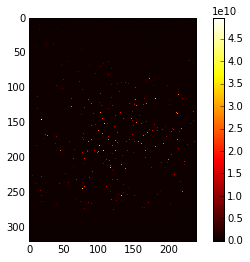

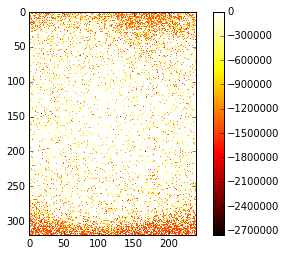

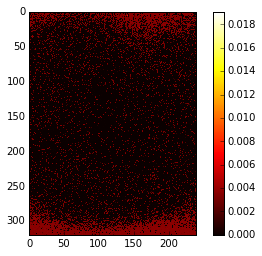

In [8]:
for i in xrange(paramGrid.shape[-1]):
    fig, ax = plt.subplots()

    cax = plt.imshow(paramGrid[:,:,i],cmap = 'hot',interpolation='nearest')

    cbar = fig.colorbar(cax)    
    plt.show()

###params space

0 1 2


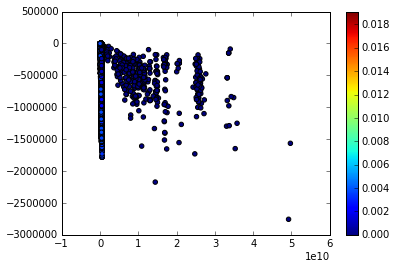

0 2 1


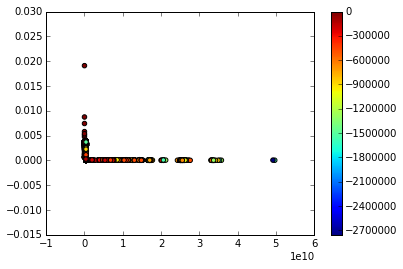

1 0 2


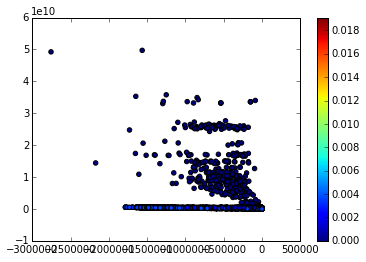

1 2 0


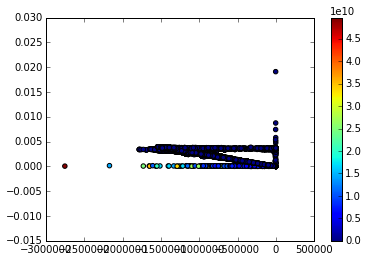

2 0 1


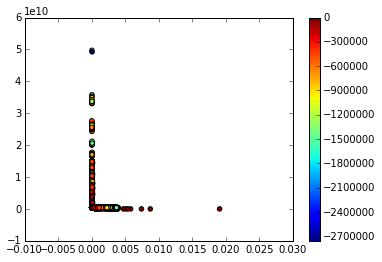

2 1 0


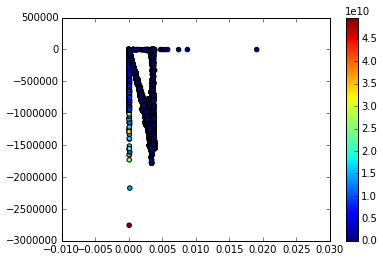

In [13]:
from itertools import permutations
for (i,j,k) in permutations(range(gammaParams.shape[-1]),3):
    fig, ax = plt.subplots()
    sct = plt.scatter(x = gammaParams[:,i],y = gammaParams[:,j],c = gammaParams[:,k])
    cbar = fig.colorbar(sct)  
    print i,j,k
    plt.show()

#stupid em


iteration 0


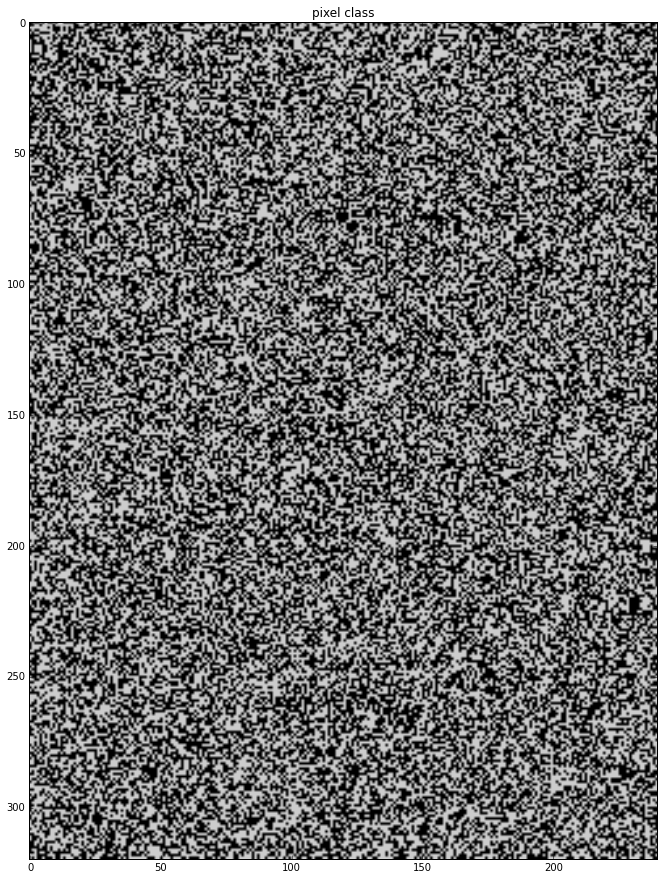

total log likelihood: -64688476.2546 with 28 infs

iteration 1


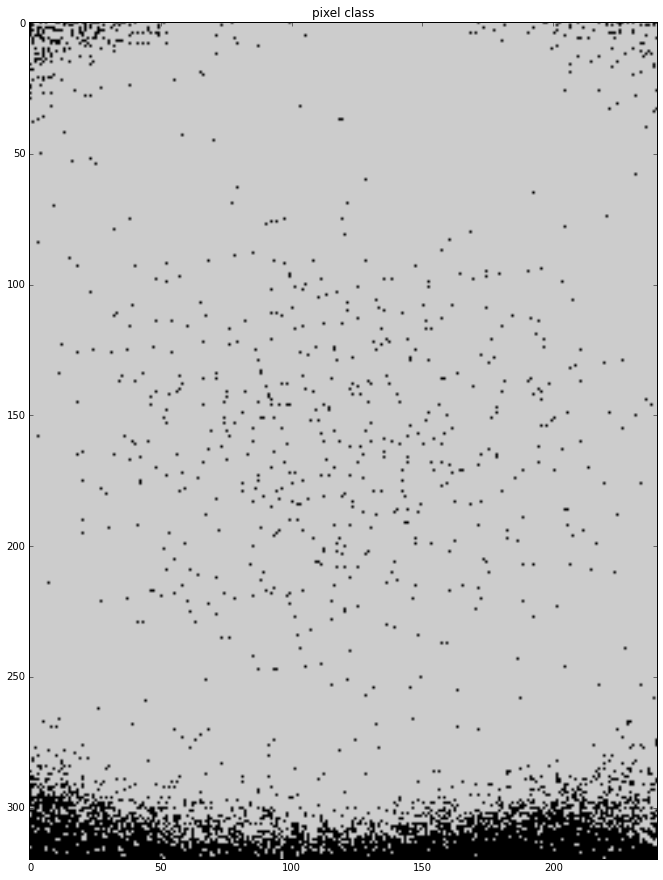

total log likelihood: -82221513.2278 with 0 infs

iteration 2


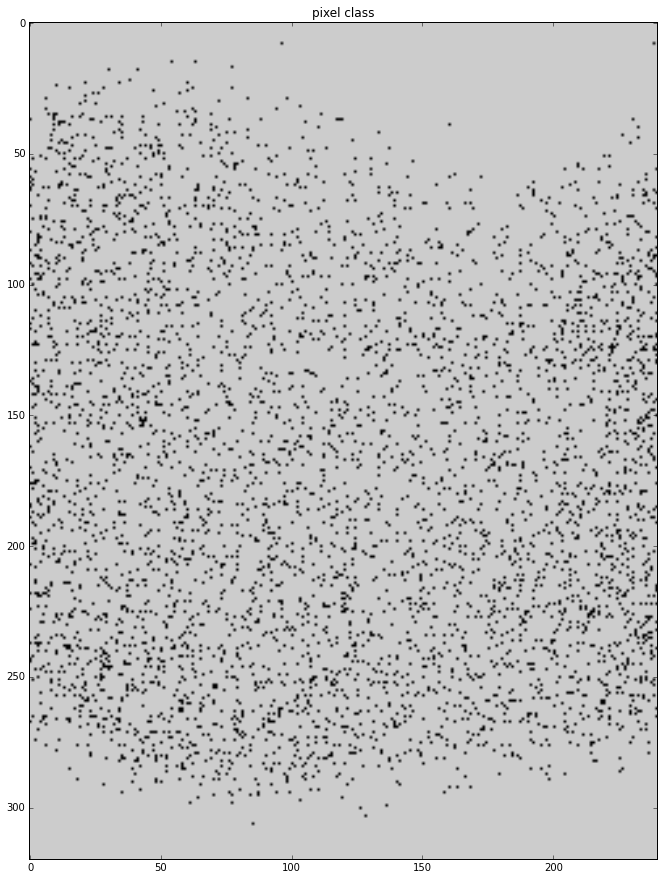

total log likelihood: -57634587.1292 with 0 infs

iteration 3


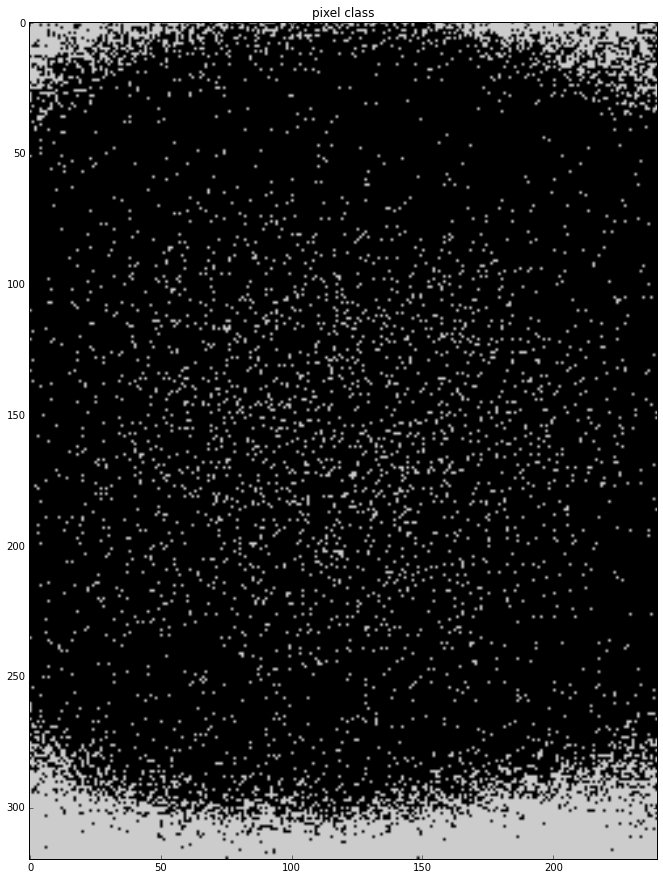

total log likelihood: -49197091.4305 with 0 infs

iteration 4


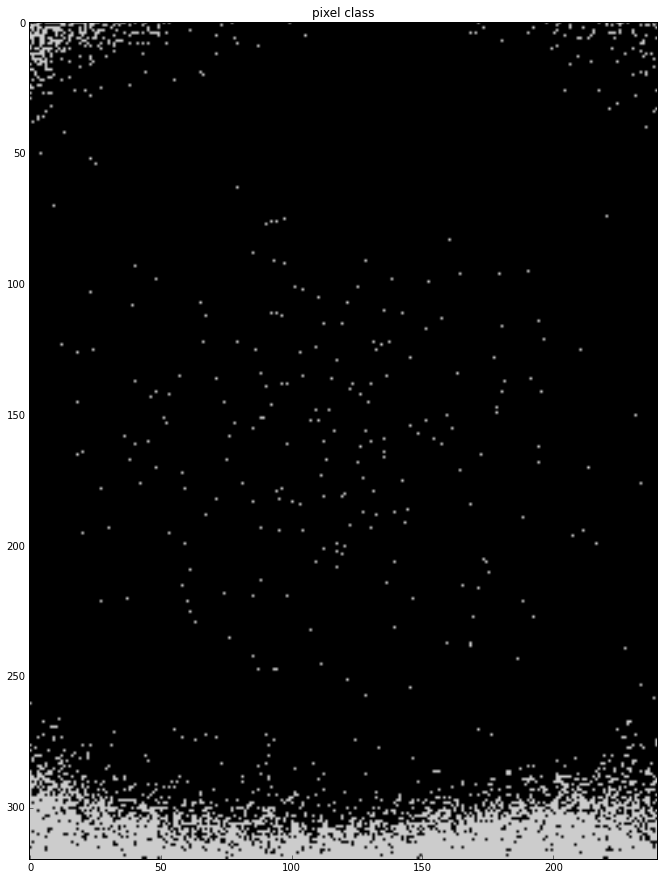

total log likelihood: -80461062.0126 with 0 infs
CPU times: user 25.6 s, sys: 172 ms, total: 25.8 s
Wall time: 25.8 s


In [17]:
%%time

n_iter = 5

classes = range(0,2)
values = np.arange(hists.shape[-1])


pixelClass = np.random.choice(classes, size = hists.shape[:-1])
pixelLlh = np.zeros(hists.shape[:-1],dtype = np.float32)

class_pdf = { } #classes:scipy.stats.gamma
class_loglh = {} #classes: sum(logLikelihood(pixels_of_that_class))
class_hist = {} #classes: sum(hists[pixels_of_that_class,:],axis = 0)

def to_pdf(hist):  
    params = gammaWeighted.fit_weighted(hist)#,loc = 0.)
    return st.gamma(*params).pdf

def penalized_weighted_nnlf(gamma,data,weights = None):
    gammaWeighted.w = weights if (weights is not None) else np.ones(data.shape)
    return gammaWeighted._penalized_weighted_nnlf(gamma.args,data) 

for i in xrange(n_iter):
    print '\niteration',i
    plt.figure(figsize =(15,15))
    plt.imshow(pixelClass,cmap = "spectral")
    plt.title("pixel class")
    plt.show()
    
    #plt.figure(figsize =(15,15))
    #pixelLlh[pixelLlh == -np.inf] = pixelLlh.min()*2
    #plt.imshow(np.log(-pixelLlh),cmap="hot",)
    #plt.title("pixel log(-Loglikelihood)")
    #plt.show()
    
    # estimate distributions for pixel classes
    for c in classes:
        #make a comon value hist of all ptype pixels
        class_hist[c] = np.sum(hists[pixelClass == c, :],axis =0,dtype = hists.dtype)

        #make a probability distribution out of it
        class_pdf[c] = to_pdf(class_hist[c])
        class_loglh[c] = np.log(class_pdf[c](values))

        
    total_llh = 0
    n_infs = 0
    #determine pixel classes
    #joblib it!
    for ip in xrange(hists.shape[0]):
        for jp in xrange(hists.shape[1]):

            logLikelihoods = np.array([ np.sum( 
                                (hists[ip,jp,:]*class_loglh[c])[np.where(hists[ip,jp,:]!=0)] #avoid NaN-s
                                              )
                                       for c in classes ])
            pixelClass[ip,jp] = classes[logLikelihoods.argmax()]
            maxLlh = np.max(logLikelihoods)
            if np.isneginf(maxLlh):
                n_infs +=1
            else:
                total_llh +=maxLlh
            pixelLlh[ip,jp] = maxLlh
            


            
    print 'total log likelihood:',total_llh ,'with',n_infs,'infs'


##indev


iteration 0


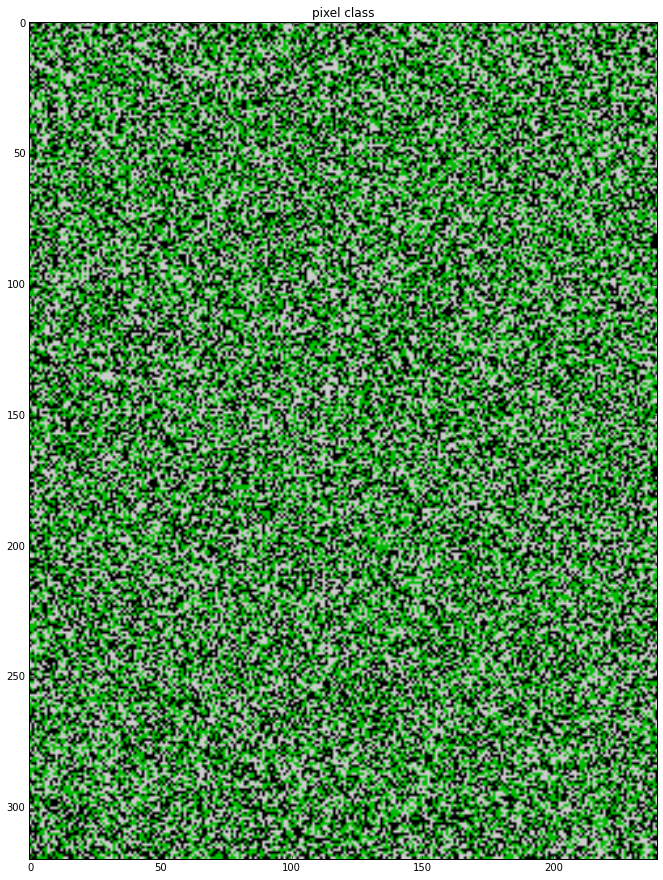

total log likelihood: 139129523.236 with 0 infs

iteration 1


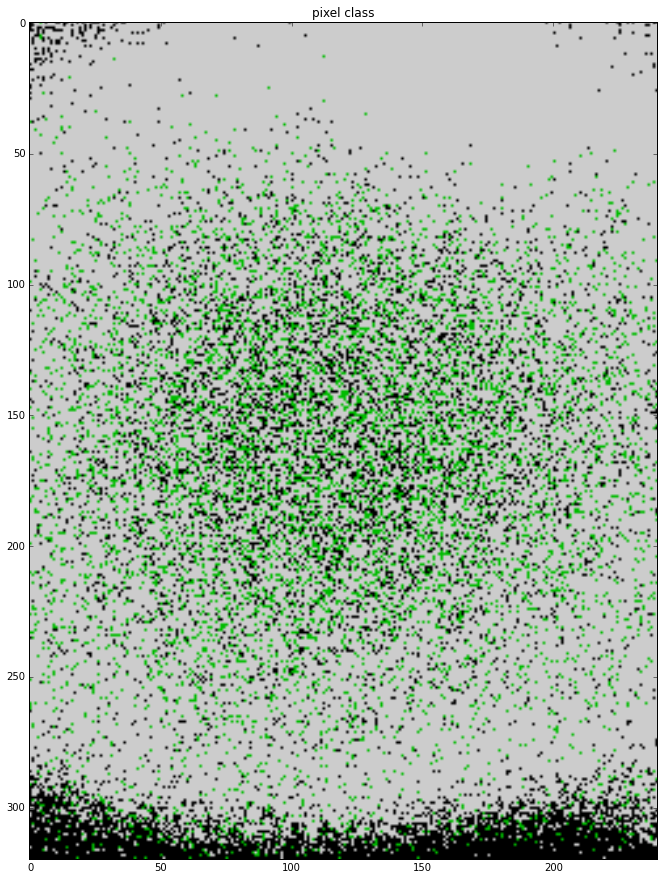

total log likelihood: 242570557.066 with 0 infs

iteration 2


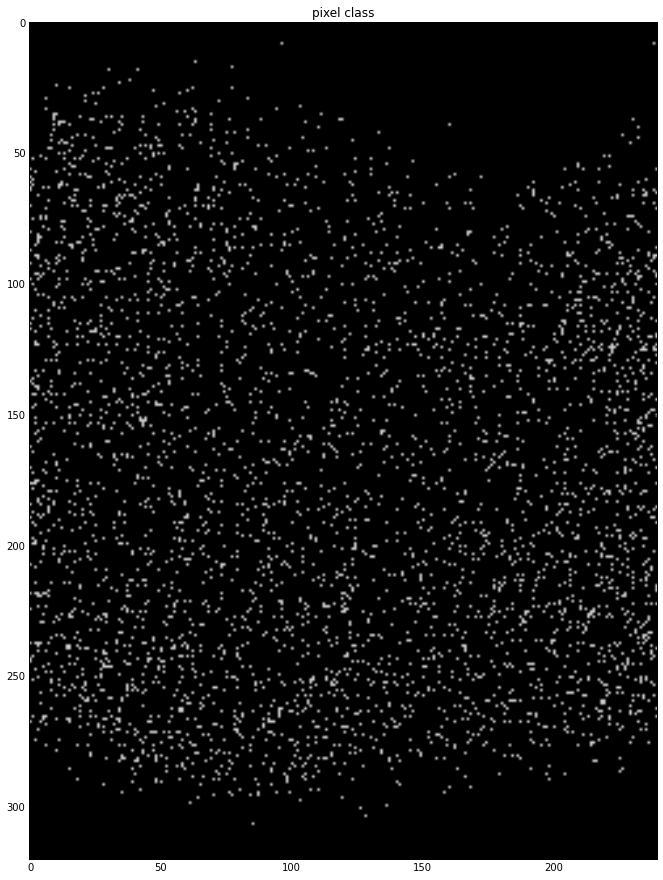

total log likelihood: 2.75829102856e+45 with 0 infs

iteration 3


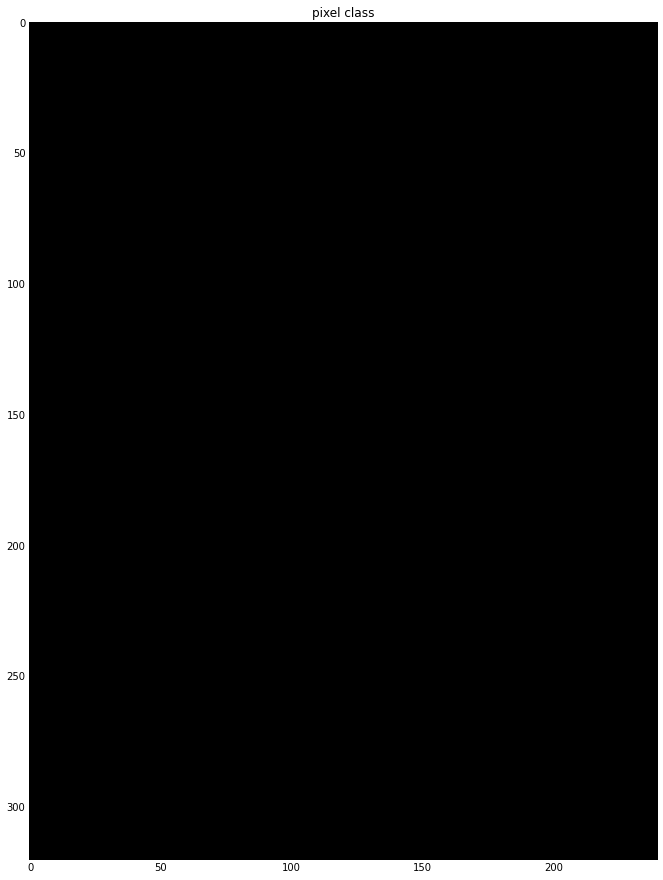

total log likelihood: 2.75829102856e+45 with 0 infs

iteration 4


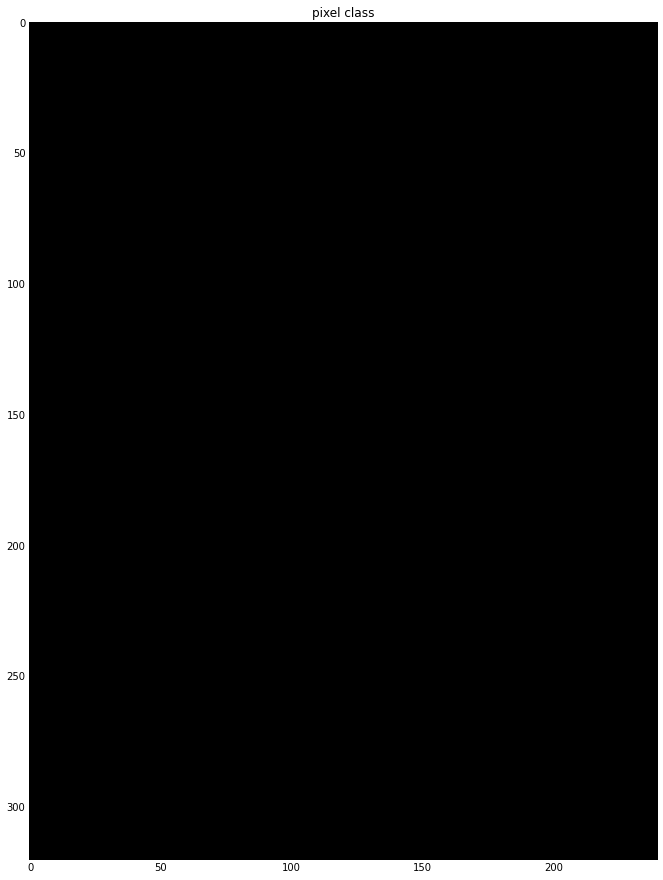

total log likelihood: 2.75829102856e+45 with 0 infs
CPU times: user 2min 12s, sys: 216 ms, total: 2min 12s
Wall time: 2min 12s


In [20]:
%%time

n_iter = 5

classes = range(0,3)
values = np.arange(hists.shape[-1])


pixelClass = np.random.choice(classes, size = hists.shape[:-1])
pixelLlh = np.zeros(hists.shape[:-1],dtype = np.float32)

class_distr = { } #classes:scipy.stats.gamma
class_loglh = {} #classes: sum(logLikelihood(pixels_of_that_class))
class_hist = {} #classes: sum(hists[pixels_of_that_class,:],axis = 0)

def to_gamma(hist):  
    params = gammaWeighted.fit_weighted(hist,loc=0)
    return gammaWeighted(*params)

def penalized_weighted_nnlf(gamma,data,weights = None):
    gammaWeighted.w = weights if (weights is not None) else np.ones(data.shape)
    return gammaWeighted._penalized_weighted_nnlf(gamma.args,data) 

for i in xrange(n_iter):
    print '\niteration',i
    plt.figure(figsize =(15,15))
    plt.imshow(pixelClass,cmap = "spectral")
    plt.title("pixel class")
    plt.show()
    
    #plt.figure(figsize =(15,15))
    #pixelLlh[pixelLlh == -np.inf] = pixelLlh.min()*2
    #plt.imshow(np.log(-pixelLlh),cmap="hot",)
    #plt.title("pixel log(-Loglikelihood)")
    #plt.show()
    
    # estimate distributions for pixel classes
    for c in classes:
        #make a comon value hist of all ptype pixels
        class_hist[c] = np.sum(hists[pixelClass == c, :],axis =0,dtype = hists.dtype)

        #make a probability distribution out of it
        class_distr[c] = to_gamma(class_hist[c])
        class_loglh[c] = np.log(class_distr[c].pdf(values))

        
    total_llh = 0
    n_infs = 0
    #determine pixel classes
    #joblib it! also fix that 1 class convergence...somehow
    #also if it works go back to precomputed loglhs and penaltize pixels separately
    
    for ip in xrange(hists.shape[0]):
        for jp in xrange(hists.shape[1]):

            
            logLikelihoods = np.array([penalized_weighted_nnlf(class_distr[c],
                                                np.arange(hists.shape[-1]),
                                                hists[ip,jp,:]
                                        ) for c in classes])
            pixelClass[ip,jp] = classes[logLikelihoods.argmax()]
            maxLlh = np.max(logLikelihoods)
            if np.isneginf(maxLlh):
                n_infs +=1
            else:
                total_llh +=maxLlh
            pixelLlh[ip,jp] = maxLlh
            


            
    print 'total log likelihood:',total_llh ,'with',n_infs,'infs'

In [25]:
class_distr[0].pdf(values)

array([  1.06597064e-003,   5.85328332e-003,   2.32062906e-002,
         6.64815658e-002,   1.37728029e-001,   2.06492391e-001,
         2.24223049e-001,   1.76475166e-001,   1.00750120e-001,
         4.17538446e-002,   1.25708727e-002,   2.75156902e-003,
         4.38195809e-004,   5.08106207e-005,   4.29302829e-006,
         2.64496131e-007,   1.18916859e-008,   3.90442558e-010,
         9.36872371e-012,   1.64411466e-013,   2.11168856e-015,
         1.98650803e-017,   1.36971105e-019,   6.92723878e-022,
         2.57156321e-024,   7.01216770e-027,   1.40551839e-029,
         2.07233493e-032,   2.24921765e-035,   1.79828705e-038,
         1.05986208e-041,   4.60795509e-045,   1.47890528e-048,
         3.50630229e-052,   6.14522527e-056,   7.96722833e-060,
         7.64642138e-064,   5.43613423e-068,   2.86484771e-072,
         1.11992710e-076,   3.24975942e-081,   7.00456706e-086,
         1.12221066e-090,   1.33728464e-095,   1.18610208e-100,
         7.83538597e-106,   3.85770683e-